# Vectors in Drug Discovery Space
We wish to look at the topology of what chemists are testing, because it will reveal clusters of drugs that have been tested against similar targets.
To achieve this, consider $ N $ molecules tested against $ M $ targets. By creating a series of $ N $ vectors
of length $ M $, with each element in the vector representing, in some sense, if a drug-target interaction has been measured.

To group these, we'll first need a way to construct a vector:
1. $[n, m] = \begin{cases}1 \text{ if $ n $ has been tested against $ m $} \\ 0 \text{ otherwise}\end{cases} $
2. $[n, m] = \begin{cases}1 \text{ if $ n $ has been tested against $ m $ and is effective} \\ -1 \text{ if $ n $ has been tested against $ m $ and is ineffective} \\ 0 \text{ otherwise}\end{cases} $
3. $[n, m] = \begin{cases} A_{n,m} \text{ if $ n $ has been tested against $ m $ and is effective} \\ -A_{n,m} \text{ if $ n $ has been tested against $ m $ and is ineffective} \\ 0 \text{ otherwise}\end{cases} $

We also need a metric to quantify distance in this vector space:
1. Case (1) above is easy, because we can use any one of a series of metrics designed for boolean vector spaces
2. Some function of the dot product for case (2) and (3).
    1. It could be normal euclidean distance, $ \sqrt{\vec{n}\cdot\vec{n}} $.
    2. It could be $ \frac{\vec{n}\cdot\vec{n}}{\left|\vec{n}\right|\cdot\left|\vec{n}\right|} $

In [8]:
import rdkit.Chem as Chem
import kmapper as km
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from collections import Counter
import sys

Here, we define an "active/inactive" cutoff of 5.0. Most values in the ChEMBL database have activities over 1.0,
so using that as the cutoff is useless. See [1 E. B. Lenselink, G. Papadatos, N. ten Dijke, A. P. IJzerman, B. Bongers, G. J. P. van Westen, H. W. T. van Vlijmen and W. Kowalczyk, J. Cheminform., 2017, 9, 1–14.](http://dx.doi.org/10.1186/s13321-017-0232-0)

In [9]:
ACTIVITY_CUTOFF = 5.0

In [10]:
with open("../data/processed/curated_set_with_publication_year.pd.pkl", "rb") as infile:
    df = pickle.load(infile)

In [22]:
possible_targets = Counter([item for item in df["TGT_CHEMBL_ID"]])
possible_targets.most_common(50)

[('CHEMBL240', 4703),
 ('CHEMBL253', 3472),
 ('CHEMBL218', 2997),
 ('CHEMBL251', 2976),
 ('CHEMBL228', 2853),
 ('CHEMBL264', 2548),
 ('CHEMBL226', 2544),
 ('CHEMBL217', 2473),
 ('CHEMBL344', 2358),
 ('CHEMBL243', 2315),
 ('CHEMBL256', 2304),
 ('CHEMBL205', 2257),
 ('CHEMBL279', 2142),
 ('CHEMBL261', 2089),
 ('CHEMBL4235', 2020),
 ('CHEMBL244', 2010),
 ('CHEMBL222', 2003),
 ('CHEMBL233', 1998),
 ('CHEMBL4078', 1994),
 ('CHEMBL284', 1950),
 ('CHEMBL237', 1908),
 ('CHEMBL259', 1828),
 ('CHEMBL4822', 1799),
 ('CHEMBL3371', 1773),
 ('CHEMBL214', 1703),
 ('CHEMBL313', 1690),
 ('CHEMBL3594', 1678),
 ('CHEMBL203', 1659),
 ('CHEMBL224', 1643),
 ('CHEMBL4296', 1594),
 ('CHEMBL260', 1589),
 ('CHEMBL235', 1575),
 ('CHEMBL234', 1569),
 ('CHEMBL225', 1565),
 ('CHEMBL236', 1550),
 ('CHEMBL220', 1542),
 ('CHEMBL238', 1518),
 ('CHEMBL247', 1474),
 ('CHEMBL255', 1445),
 ('CHEMBL3952', 1424),
 ('CHEMBL2039', 1403),
 ('CHEMBL340', 1386),
 ('CHEMBL3242', 1380),
 ('CHEMBL204', 1347),
 ('CHEMBL5071', 1332),


In [12]:
possible_drugs = Counter([item for item in df["CMP_CHEMBL_ID"]])
matrix_size = len(possible_drugs) * len(possible_targets) * 16 / (1000 * 1000)
print("There are", len(possible_drugs), "drugs interacting with", len(possible_targets),
      "targets. This matrix will be approximately of size", matrix_size, "MB")

There are 204085 drugs interacting with 1227 targets. This matrix will be approximately of size 4006.59672 MB


In [13]:
%load_ext memory_profiler
%memit vector_df = pd.DataFrame(0, columns=possible_drugs.keys(), index=possible_targets.keys(), dtype=np.int8)

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 1701.70 MiB, increment: 477.67 MiB


In [14]:
counted = 0
for index, row in df.iterrows():
    drug = row["CMP_CHEMBL_ID"]
    target = row["TGT_CHEMBL_ID"]
    if not counted % 100001:
        print("Counted up to", counted)
    if row["BIOACT_PCHEMBL_VALUE"] > ACTIVITY_CUTOFF:
        vector_df[drug][target] = 1
    else:
        vector_df[drug][target] = -1
    counted += 1

Counted up to 0
Counted up to 100001
Counted up to 200002


KeyboardInterrupt: 

In [16]:
def dissimilarity(vec1, vec2, metric="euclidean"):
    """
    Takes in two vectors with values +1 and -1. Computes how far away they are
    in according to the metric.
    Current metrics:
    - Euclidean, computes sqrt(vec1 dot vec2)
    - Cosine distance
    - Tanimoto
    """
    metric = metric.lower()
    if metric == "euclidean":
        distance = np.abs(vec1 - vec2)
        return np.sqrt(np.dot(distance, distance))
    
    if metric == "cosine":
        return 1.0 - np.dot(vec1, vec2)/(np.sqrt(np.dot(vec1, vec1)) * np.sqrt(np.dot(vec2, vec2)))
                                   
    if metric == "tanimoto":
        return 1.0 - np.dot(vec1, vec2) / (np.dot(vec1, vec1) + np.dot(vec2, vec2) - np.dot(vec1, vec2))                 
    

In [17]:
distance = dissimilarity(vector_df.loc["CHEMBL3246"].values, vector_df.loc["CHEMBL3246"].values)
print(distance)
distance = dissimilarity(vector_df.loc["CHEMBL3246"].values, vector_df.loc["CHEMBL209"].values)
print(distance)

0.0
8.945


In [ ]:
distance = dissimilarity(vector_df.loc["CHEMBL3246"].values, vector_df.loc["CHEMBL3246"].values, "cosine")
print(distance)
distance = dissimilarity(vector_df.loc["CHEMBL3246"].values, vector_df.loc["CHEMBL209"].values, "cosine")
print(distance)

In [ ]:
distance = dissimilarity(vector_df.loc["CHEMBL3246"].values, vector_df.loc["CHEMBL3246"].values, "tanimoto")
print(distance)
distance = dissimilarity(vector_df.loc["CHEMBL3246"].values, vector_df.loc["CHEMBL209"].values, "tanimoto")
print(distance)

In [31]:
mask = vector_df.loc["CHEMBL218"].values != 0
sub_df = (vector_df.T[mask])
sub_df.shape

(2997, 1227)

In [32]:
count = 0
distance_matrix = np.empty([len(sub_df), len(sub_df)])
print(distance_matrix.shape)
with open("distance_matrix.csv", "w") as fi:
    for drug_index in range(len(sub_df)):
        if not drug_index % 100:
            print(drug_index)
        drug = sub_df.iloc[drug_index].values
        for other_index in range(drug_index):
            other_drug = sub_df.iloc[other_index].values
            distance = dissimilarity(drug, other_drug, "tanimoto")
            distance_matrix[drug_index, other_index] = distance
            distance_matrix[other_index, drug_index] = distance

(2997, 2997)
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


[[0.         0.94736842 0.94444444 ... 0.93333333 0.9375     0.9375    ]
 [0.94736842 0.         0.7142857  ... 0.8        0.83333333 0.59999999]
 [0.94444444 0.7142857  0.         ... 0.75       0.8        0.5       ]
 ...
 [0.93333333 0.8        0.75       ... 0.         0.5        0.5       ]
 [0.9375     0.83333333 0.8        ... 0.5        0.         0.66666666]
 [0.9375     0.59999999 0.5        ... 0.5        0.66666666 0.        ]]
3387135 (2997, 2997)


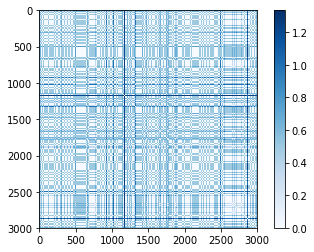

In [33]:
%matplotlib inline
print(distance_matrix)
import matplotlib.pyplot as plt
plt.imshow(distance_matrix, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()

print(np.sum(distance_matrix == 0), distance_matrix.shape)

In [26]:
(df.T)

,CHEMBL209 - CHEMBL19831,CHEMBL209 - CHEMBL332157,CHEMBL209 - CHEMBL52427,CHEMBL209 - CHEMBL353213,CHEMBL209 - CHEMBL100672,CHEMBL209 - CHEMBL99622,CHEMBL209 - CHEMBL256892,CHEMBL209 - CHEMBL101041,CHEMBL209 - CHEMBL168411,CHEMBL209 - CHEMBL47207,...,CHEMBL3246 - CHEMBL3084711,CHEMBL3246 - CHEMBL3084708,CHEMBL3246 - CHEMBL3084715,CHEMBL3246 - CHEMBL3084707,CHEMBL3246 - CHEMBL3084710,CHEMBL3246 - CHEMBL3084717,CHEMBL3246 - CHEMBL3084713,CHEMBL3246 - CHEMBL3304900,CHEMBL3246 - CHEMBL3274623,CHEMBL3246 - CHEMBL3305786
BIOACT_PCHEMBL_VALUE,7.78,8.19,6.89,5.17,7.39,9.92,8.09,9.3,4.73,6.77,...,7,5.8,4.95,7.1,5.37,5.72,5.72,4.51,4.63,4.17
CMP_ACD_LOGD,-2.86,0.05,1.72,1.74,1.62,2.24,-1.4,1.15,2.43,-1.51,...,0.43,4.42,2.08,-3.73,-0.08,5,4.51,1.46,2.66,0.28
CMP_ACD_LOGP,0.58,2,3.72,1.94,1.62,2.24,0.6,1.15,2.43,-0.51,...,0.43,4.42,4.05,-0.23,-0.08,5,6.48,3.11,2.66,4.03
CMP_ALOGP,-0.99,1.19,4.75,0.5,2.11,3.07,-0.29,2.41,2.99,3.5,...,0.63,3.11,1.7,1.17,1.16,2.27,2.5,2.58,1,1.62
CMP_AROMATIC_RINGS,1,4,4,3,0,1,2,0,4,3,...,1,2,1,1,1,1,2,2,1,1
CMP_CHEMBL_ID,CHEMBL19831,CHEMBL332157,CHEMBL52427,CHEMBL353213,CHEMBL100672,CHEMBL99622,CHEMBL256892,CHEMBL101041,CHEMBL168411,CHEMBL47207,...,CHEMBL3084711,CHEMBL3084708,CHEMBL3084715,CHEMBL3084707,CHEMBL3084710,CHEMBL3084717,CHEMBL3084713,CHEMBL3304900,CHEMBL3274623,CHEMBL3305786
CMP_FULL_MWT,568.58,462.48,341.41,430.5,166.22,234.31,446.52,222.28,619.71,445.53,...,232.28,298.38,234.29,221.25,246.3,251.34,296.36,306.4,230.31,256.34
CMP_HBA,11,7,2,5,2,3,6,3,6,4,...,4,3,3,3,4,3,4,2,2,2
CMP_HBD,5,4,4,2,0,0,5,0,3,3,...,1,0,1,1,0,0,0,0,0,0
CMP_HEAVY_ATOMS,39,33,26,32,12,16,31,16,46,33,...,17,22,17,16,18,17,22,23,17,19


In [34]:
lens = np.array([np.sum(np.abs(sub_df.T[drug].values)) for drug in sub_df.T])

In [44]:
import hdbscan
from IPython.display import SVG, IFrame
mapper = km.KeplerMapper(verbose=1)
graph = mapper.map(lens,
                   X=distance_matrix,
                   precomputed=True,
                   cover=km.Cover(n_cubes=40, perc_overlap=0.80),
                   clusterer=hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=3, min_samples=1))
mapper.visualize(graph, path_html="2019-04-04-mb-vectors-in-drug-testing-space-map.html",
                 title="Vectors in Drug Testing Space", color_function=lens)
IFrame("2019-04-04-mb-vectors-in-drug-testing-space-map.html", 800, 600)

KeplerMapper(verbose=1)
Mapping on data shaped (2997, 2997) using lens shaped (2997,)

Creating 40 hypercubes.

Created 216 edges and 103 nodes in 0:00:03.052173.
Wrote visualization to: 2019-04-04-mb-vectors-in-drug-testing-space-map.html
